In [1]:
import numpy as np
from numpy.typing import NDArray
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style()

In [32]:
hx, hy = 0.01, 0.01

class Solution:

    hx, hy = hx or 0.005 , hy or 0.005

    nx, ny = round(np.pi / hx), round(np.pi / hy)

    x_arr = np.linspace(0, np.pi, nx)
    y_arr = np.linspace(0, np.pi, ny)

    x_arr, y_arr = np.meshgrid(x_arr, y_arr, indexing='ij')
    k = np.arange(nx * ny, dtype=int).reshape((nx, ny))

    q1 = 10
    q2 = 15

    @classmethod
    def init_lil_matrix(cls) -> sp.lil_matrix:
        """
        Инициализация и заполнение разреженной матрицы в формате LIL.

        Создает разреженную матрицу с коэффициентами для задачи, основываясь на
        сетке с шагами hx и hy. Учитывает граничные условия через периодичность индексов.

        :return: Разреженная матрица в формате LIL.
        :rtype: sp.lil_matrix
        """
        L = sp.lil_matrix((cls.nx * cls.ny, cls.nx * cls.ny))

        for i in range(cls.nx):
            for j in range(cls.ny):
                L[cls.k[i, j], cls.k[i, j]] += 2.0 / cls.hx ** 2 + 2.0 / cls.hy ** 2 + 1
                L[cls.k[i, j], cls.k[(i - 1) % cls.nx, j]] = -1.0 / cls.hx ** 2
                L[cls.k[i, j], cls.k[(i + 1) % cls.nx, j]] = -1.0 / cls.hx ** 2
                L[cls.k[i, j], cls.k[i, (j - 1) % cls.ny]] = -1.0 / cls.hy ** 2
                L[cls.k[i, j], cls.k[i, (j + 1) % cls.ny]] = -1.0 / cls.hy ** 2

        return L

    @classmethod
    def right_part(cls, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Вычисление правой части уравнения для заданных массивов x и y.

        Используется для вычисления правой части задачи, зависящей от переменных x и y.

        :param x: Массив координат по оси x.
        :type x: np.ndarray
        :param y: Массив координат по оси y.
        :type y: np.ndarray
        :return: Массив значений правой части.
        :rtype: np.ndarray
        """
        return np.sin(2 * x) * np.exp(-np.cos(2 * y)) * (2 * np.cos(2 * y) - 1) ** 2

    @staticmethod
    def true_solution(x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Вычисление аналитического решения задачи для заданных массивов x и y.

        Возвращает истинное решение задачи для проверки численного результата.

        :param x: Массив координат по оси x.
        :type x: np.ndarray
        :param y: Массив координат по оси y.
        :type y: np.ndarray
        :return: Массив значений истинного решения.
        :rtype: np.ndarray
        """
        return np.sin(2 * x) * np.exp(-np.cos(2 * y))

    @staticmethod
    def draw_result(u_numerical: np.ndarray, u_true: np.ndarray) -> float:
        """
        Отображение численного решения, аналитического решения и их разности.

        Визуализирует результаты в виде трех изображений: численного решения,
        истинного решения и их абсолютной разницы. Также возвращает среднюю ошибку.

        :param u_numerical: Численное решение.
        :type u_numerical: np.ndarray
        :param u_true: Истинное решение.
        :type u_true: np.ndarray
        :return: Среднее значение разности между численным и истинным решениями.
        :rtype: float
        """
        fig, ax = plt.subplots(1, 3, figsize=[10,8])
        diff = np.abs(u_numerical - u_true)
        ax[0].imshow(u_numerical, cmap='inferno', extent=[0, np.pi, 0, np.pi],  origin='lower')
        ax[1].imshow(u_true, cmap='inferno', extent=[0, np.pi, 0, np.pi],  origin='lower')
        ax[2].imshow(diff, cmap='inferno', extent=[0, np.pi, 0, np.pi],  origin='lower')
        return diff.mean()
    
    @classmethod
    def grid_function(cls) -> NDArray:
        """
        Функция генерирует сетку, где значения чередуются между двумя заданными параметрами.

        Возвращает:
            NDArray: Сетка значений.
        
        Действия функции:
            1. Создает булеву маску на основе суммы индексов сетки (nx и ny).
               Маска определяет, где должны быть расположены значения q1 или q2.
            2. Использует np.where для применения маски к двум различным значениям (q1 и q2),
               создавая таким образом чередующуюся сетку значений.
        """
        size_x, size_y = cls.x_arr.shape
        grid = np.zeros_like(cls.x_arr)
        grid[0][0] = cls.q1
        grid[size_x // 2][0] = -cls.q2
        grid[size_x // 2][-1] = -cls.q2
        grid[0][size_y // 2] = -cls.q2
        grid[-1][size_y // 2] = -cls.q2
        grid[size_x // 2][size_y // 2] = cls.q1
        grid[-1][-1] = cls.q1
        grid[0][-1] = cls.q1
        grid[-1][0] = cls.q1
        return grid

    @classmethod
    def equipotential_surfaces(cls, numerical):
        """
        Функция строит эквипотенциальные поверхности на основе заданных данных.

        Параметры:
            numerical (np.ndarray): Двумерный массив данных для построения графика.
        
        Возвращает:
            None

        Действия функции:
            1. Создает новую фигуру с указанными размерами.
            2. Строит линии уровня на основе входных данных (y_arr, x_arr и numerical).
               Используется colormap 'plasma' для визуализации.
            3. Добавляет подписи к построенным линиям уровня.
            4. Устанавливает заголовок графика как "Эквипотенциальные поверхности".
        """
        plt.figure(figsize=(8, 6))
        contour = plt.contour(cls.y_arr, cls.x_arr, numerical, levels=20, cmap='plasma')  # Построение линий уровня
        plt.clabel(contour, inline=True, fontsize=8)  # Добавление подписей к линиям

        # Дополнительные настройки
        plt.title('Эквипотенциальные поверхности')

    @classmethod
    def main_a(cls) -> None:
        """
        Основной метод для решения задачи и визуализации результатов.

        Инициализирует разреженную матрицу, решает систему линейных уравнений,
        вычисляет численное и истинное решения, и выводит среднюю ошибку.
        """
        L_lil_matrix = cls.init_lil_matrix()
        L_scr = L_lil_matrix.tocsr()
        r_part = cls.right_part(cls.x_arr, cls.y_arr)
        r_part_flatten = r_part.flatten()
        cls.solved_a = spsolve(L_scr, r_part_flatten)
        cls.solved_2d_a = cls.solved_a.reshape(cls.nx, cls.ny)
        u_true = cls.true_solution(cls.x_arr, cls.y_arr)
        print('Средняя ошибка составляет', cls.draw_result(cls.solved_2d_a, u_true))

    def main_b(cls) -> None:
        """
        Основной метод для решения задачи и визуализации результатов.

        Инициализирует разреженную матрицу, решает систему линейных уравнений,
        вычисляет численное и истинное решения, и выводит среднюю ошибку.
        """
        L_lil_matrix = cls.init_lil_matrix()
        L_scr = L_lil_matrix.tocsr()
        r_part =  cls.grid_function()
        
        r_part_flatten = r_part.flatten()
        cls.solved_b = spsolve(L_scr, r_part_flatten)
        cls.solved_2d_b = cls.solved_b.reshape(cls.nx, cls.ny)
        cls.equipotential_surfaces(cls.solved_2d_b)

solver = Solution()

Средняя ошибка составляет 0.003857334227720029


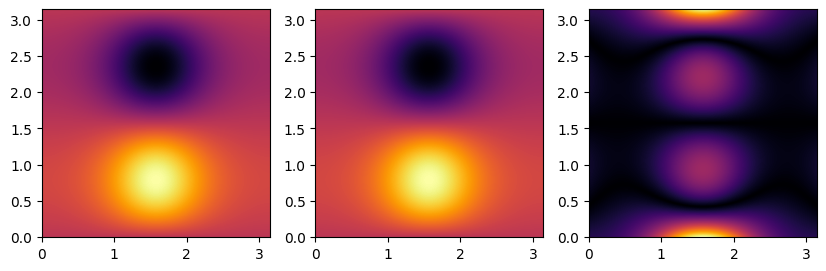

In [20]:
solver.main_a()

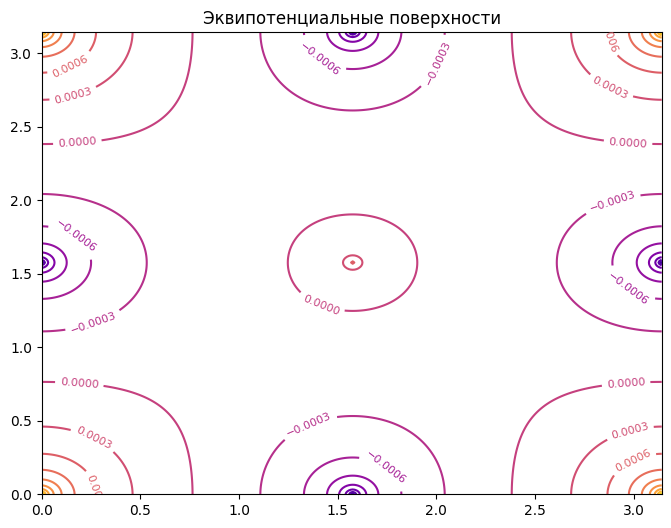

In [33]:
solver.main_b()